In [2]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

from scipy.linalg import eig
import osmnx as ox

In [3]:
# =============================================================================
# Create the network

# G = nx.DiGraph()
# G.add_edges_from([(0,1), (1,0), (1,2), (2,3), (2,1), (1,3), (3,2)])
# nx.draw(G, with_labels=True, node_color='dodgerblue', node_size=100,width=2,edge_color='0.5',linewidths=1,edgecolors='b')

# =============================================================================
def Graph_to_global_time(G):
    n = nx.number_of_nodes(G)
    node_order = list(G.nodes())

    # Construct the transition matrix P
    A = nx.to_numpy_array(G, nodelist=node_order, weight=None, dtype=int)
    rowsums = np.sum(A, axis=1)
    delta = np.diag(1/rowsums)
    # the transition probability is a fraction of the out degree
    P = np.matmul(delta,A) # stochastic by rows

    # =============================================================================
    # Construct the fundamental matrix Z
    I = np.identity(n, dtype=int)
    e = np.ones(n, dtype=int)

    # calculate the stationary vector pi
    ev,lv = eig(P,left=True, right=False) # eig values and left eig vectors
    ix = np.argsort(ev)[-1] # dominant eigvalue index
    dom_eigenvector = lv[:,ix].real
    pi = (1/np.sum(dom_eigenvector))*dom_eigenvector # probabiltiy vector

    W = np.outer(e,pi) # pi in every row
    Z = np.linalg.inv(I - P + W)

    # =============================================================================
    # Construct the mean first passage matrix M
    E = np.ones((n,n), dtype=int)
    Z_diag = np.diag(np.diag(Z))
    D = np.diag(1/pi)
    mat1 = (I - Z + np.matmul(E,Z_diag))
    M = np.matmul(mat1,D)
    np.fill_diagonal(M, 0) # set M[i][i]=0

    # =============================================================================
    # Calculate the global time tau
    pi_mat = np.outer(pi,e) # pi in every column
    tau_mat = pi_mat * M 
    tau_i = np.sum(tau_mat,axis=0) # vector of tau values
    tau_global = np.sum(tau_i) / n

    return tau_global

In [4]:

def cycle_with_attached_triangles(n: int, mode: str = "directed") -> nx.DiGraph:
    """
    Construct a graph consisting of:
      - a central cycle of length n
      - a bidirected triangle attached at each cycle vertex

    Parameters
    ----------
    n : int
        Size of the central cycle (n >= 3 recommended).
    mode : {"directed", "undirected"}
        If "directed", the central cycle is directed.
        If "undirected", the central cycle is bidirected.

    Returns
    -------
    nx.DiGraph
        The resulting directed graph.
    """

    if mode not in {"directed", "undirected"}:
        raise ValueError("mode must be 'directed' or 'undirected'")

    G = nx.DiGraph()

    # --- Central cycle vertices ---
    center_nodes = list(range(n))
    G.add_nodes_from(center_nodes)

    # --- Central cycle edges ---
    for i in range(n):
        u = i
        v = (i + 1) % n

        G.add_edge(u, v)
        if mode == "undirected":
            G.add_edge(v, u)

    # --- Attach bidirected triangles ---
    next_node = n
    for v in center_nodes:
        a = next_node
        b = next_node + 1
        next_node += 2

        G.add_nodes_from([a, b])

        # Triangle edges (fully bidirected)
        triangle_edges = [
            (v, a), (a, v),
            (a, b), (b, a),
            (b, v), (v, b)
        ]

        G.add_edges_from(triangle_edges)

    return G


In [5]:
from copy import deepcopy

def cycle_with_attached_graph(
    n: int,
    attachment: nx.Graph,
    attachment_node,
    mode: str = "directed",
) -> nx.DiGraph:
    """
    Construct a graph consisting of:
      - a central cycle of length n
      - a copy of `attachment` attached at each cycle vertex

    Parameters
    ----------
    n : int
        Size of the central cycle.
    attachment : nx.Graph or nx.DiGraph
        Graph to attach at each cycle vertex.
    attachment_node :
        Node in `attachment` that will be identified with the cycle vertex.
    mode : {"directed", "undirected"}
        If "directed", the central cycle is directed.
        If "undirected", the central cycle is bidirected.

    Returns
    -------
    nx.DiGraph
        Resulting directed graph.
    """

    if mode not in {"directed", "undirected"}:
        raise ValueError("mode must be 'directed' or 'undirected'")

    if attachment_node not in attachment:
        raise ValueError("attachment_node must be a node in attachment")

    G = nx.DiGraph()

    # --- Central cycle ---
    center_nodes = list(range(n))
    G.add_nodes_from(center_nodes)

    for i in range(n):
        u = i
        v = (i + 1) % n
        G.add_edge(u, v)
        if mode == "undirected":
            G.add_edge(v, u)

    # --- Attach motif at each cycle node ---
    next_node = n

    for v in center_nodes:
        # mapping from attachment nodes to new nodes
        mapping = {}

        for u in attachment.nodes():
            if u == attachment_node:
                mapping[u] = v
            else:
                mapping[u] = next_node
                next_node += 1

        # add edges
        if attachment.is_directed():
            for x, y in attachment.edges():
                G.add_edge(mapping[x], mapping[y])
        else:
            for x, y in attachment.edges():
                G.add_edge(mapping[x], mapping[y])
                G.add_edge(mapping[y], mapping[x])

    return G


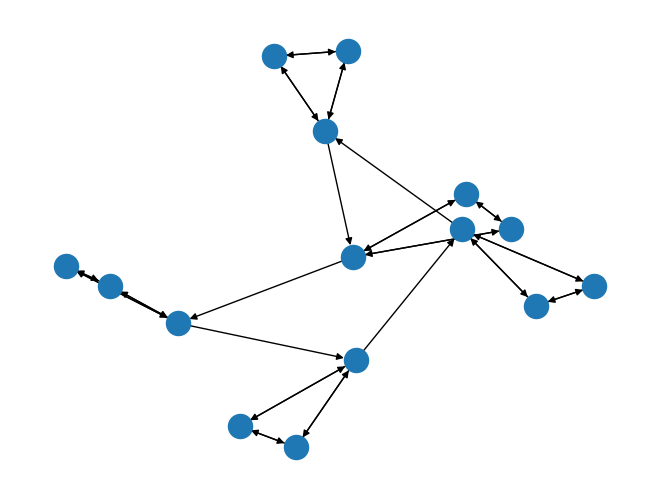

In [6]:
G = cycle_with_attached_triangles(5, mode="directed")
pos = nx.spring_layout(G)
nx.draw(G, pos=pos)

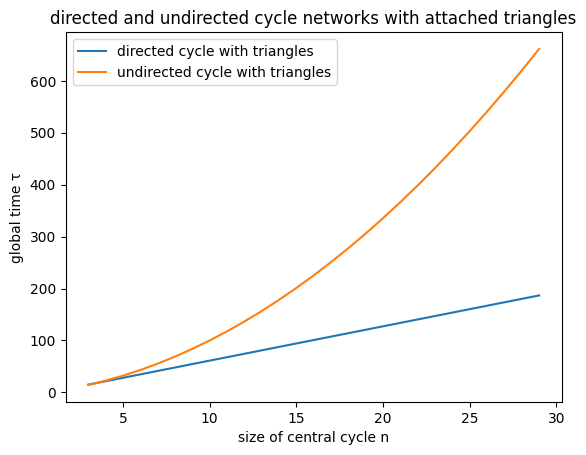

In [7]:
number = 30
vals_di = np.zeros(number-3)
vals_un = np.zeros(number-3)
for n in range(3,number):
    C_di = cycle_with_attached_triangles(n, mode="directed")  
    C_un = cycle_with_attached_triangles(n, mode="undirected")
    tau_di = Graph_to_global_time(C_di)
    tau_un = Graph_to_global_time(C_un)
    vals_di[n-3] = tau_di
    vals_un[n-3] = tau_un
plt.plot(range(3,number), vals_di, label='directed cycle with triangles')
plt.plot(range(3,number), vals_un, label='undirected cycle with triangles')  
plt.title('directed and undirected cycle networks with attached triangles')
plt.xlabel('size of central cycle n') 
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel('global time τ')
plt.legend()
    

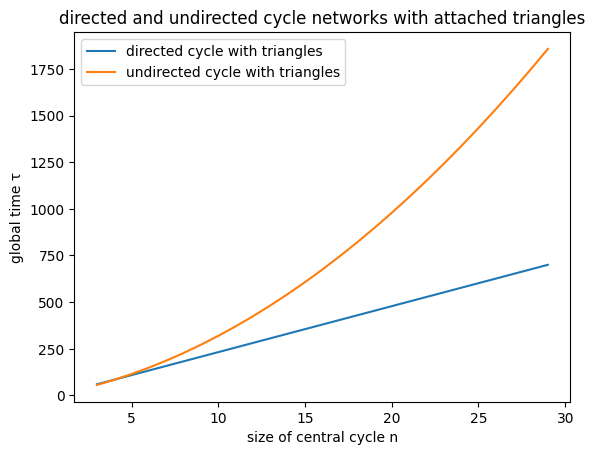

In [8]:
attachment = nx. erdos_renyi_graph(8, 0.3)

number = 30
vals_di = np.zeros(number-3)
vals_un = np.zeros(number-3)
for n in range(3,number):
    C_di = cycle_with_attached_graph(n, attachment, 0, mode="directed")  
    C_un = cycle_with_attached_graph(n, attachment, 0, mode="undirected")
    tau_di = Graph_to_global_time(C_di)
    tau_un = Graph_to_global_time(C_un)
    vals_di[n-3] = tau_di
    vals_un[n-3] = tau_un
plt.plot(range(3,number), vals_di, label='directed cycle with triangles')
plt.plot(range(3,number), vals_un, label='undirected cycle with triangles')  
plt.title('directed and undirected cycle networks with attached triangles')
plt.xlabel('size of central cycle n') 
plt.ylabel('global time τ')
plt.legend()

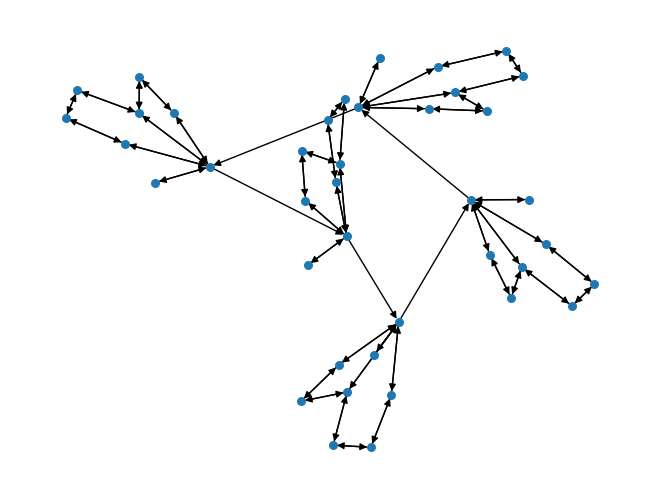

In [9]:
example = cycle_with_attached_graph(5, attachment, 0, mode="directed")  
nx.draw(example, node_size=30)